# Facial Expressioin Recognition using ViT


In [ ]:
!pip install datasets
!pip install evaluate
!pip install --upgrade transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00


# Data Source

- The data is downloaded from the Kaggle: 'msambare/fer2013'. This dataset is used for training purpose.

- Another dataset mohammedabdekdayem/testing-fer is used for final testing purpose.


In [ ]:
import os
import kagglehub

msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')
mohammedabdeldayem_testing_fer_path = kagglehub.dataset_download('mohammedabdeldayem/testing-fer')


# print(os.path.exists(mahmoudima_mma_facial_expression_path))
print(f'Checking if the datapath for train data exists: {os.path.exists(msambare_fer2013_path)}')
print(f'Checking if the datappath for test data exists: {os.path.exists(mohammedabdeldayem_testing_fer_path)}')

Checking if the datapath for train data exists: True
Checking if the datappath for test data exists: True


In [ ]:
!ls /kaggle/input/fer2013

test  train


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,f1_score
import cv2
import os
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import load_dataset,concatenate_datasets
# from evaluate import load # Import load_metric using the correct path
import evaluate
from huggingface_hub import notebook_login
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, pipeline
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)
import itertools


from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
# pre-trained model from which to fine-tune
model_checkpoint = "motheecreator/vit-Facial-Expression-Recognition"

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dshrestha14","key":"247f50ec79459a54218c169e925c10c7"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download FER2013 dataset
!kaggle datasets download -d msambare/fer2013
!unzip -q fer2013.zip -d fer2013


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 987MB/s]


In [ ]:
from datasets import load_dataset

train_dataset = load_dataset(
    "imagefolder",
    data_dir="/content/fer2013/"
)


ValueError: Invalid pattern: '**' can only be an entire path component

In [ ]:
train_dataset = ImageFolder(root="/kaggle/input/fer2013/train")


In [ ]:
# # Loading the test dataset
# test_dataset = load_dataset(
#     "imagefolder",
#     data_dir="/kaggle/input/fer2013/test")

Resolving data files:   0%|          | 0/7178 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# train_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 28709
    })
})

In [ ]:
fer_dataset = load_dataset("imagefolder", data_dir="/kaggle/input/fer2013")

ValueError: Invalid pattern: '**' can only be an entire path component

In [ ]:
from datasets import DatasetDict, ClassLabel

dataset = DatasetDict()

In [ ]:
dataset = fer_dataset

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 28709
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 7178
    })
})

In [ ]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=48x48>,
 'label': 0}

# Visualizing the Sample of Training data

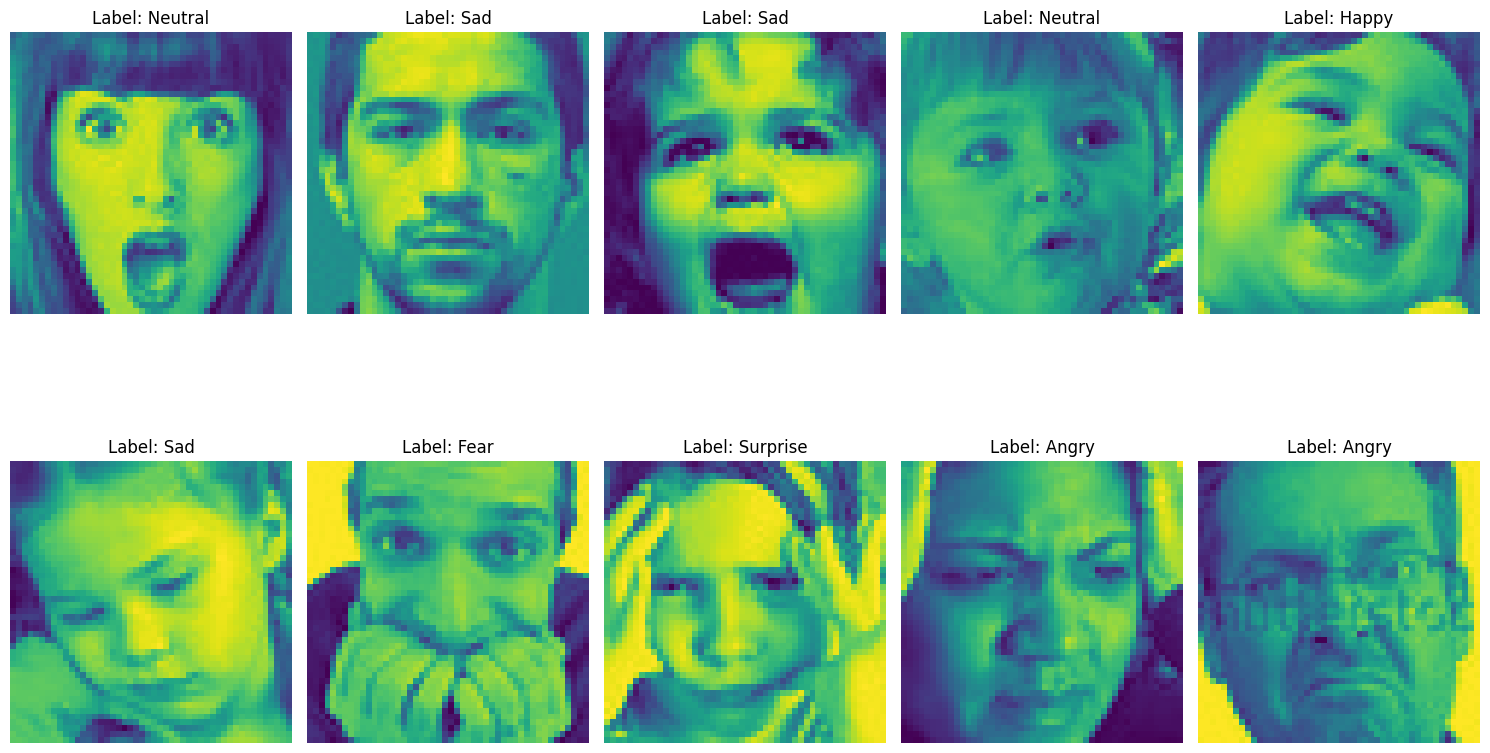

In [ ]:
# prompt: visualize the 10 sample of data randomly choosing from the Training dataset, showcase the labels too and map the labels to original labels too

import random
import matplotlib.pyplot as plt


# Define the mapping between numeric labels and original labels
label_mapping = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}


# Sample 10 random images from the training set
num_samples = 10
random_indices = random.sample(range(len(dataset['train'])), num_samples)
samples = [dataset['train'][i] for i in random_indices]

# Visualize the samples
plt.figure(figsize=(15, 10))
for i, sample in enumerate(samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample['image'])
    plt.title(f"Label: {label_mapping[sample['label']]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Data Understanding

## Label Distribution

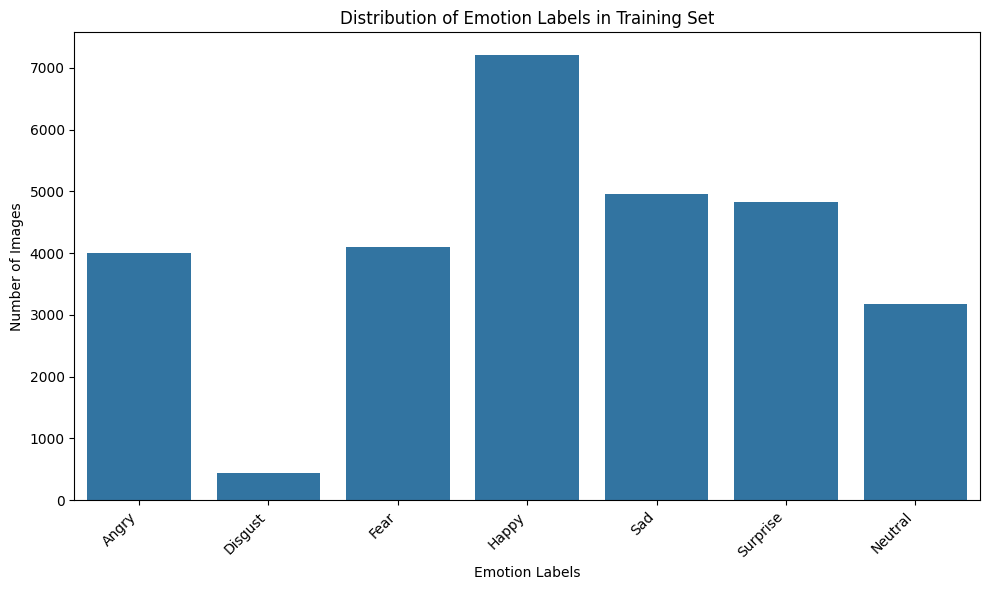

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_label_distribution(data:str='train'):
  # Count the occurrences of each label
  label_counts = {}
  for label in dataset[data]['label']:
      original_label = label_mapping[label]
      label_counts[original_label] = label_counts.get(original_label, 0) + 1

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
  plt.xlabel("Emotion Labels")
  plt.ylabel("Number of Images")
  plt.title("Distribution of Emotion Labels in Training Set")
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.tight_layout()
  plt.show()

# plot labels distribution in training data samples
plot_label_distribution()

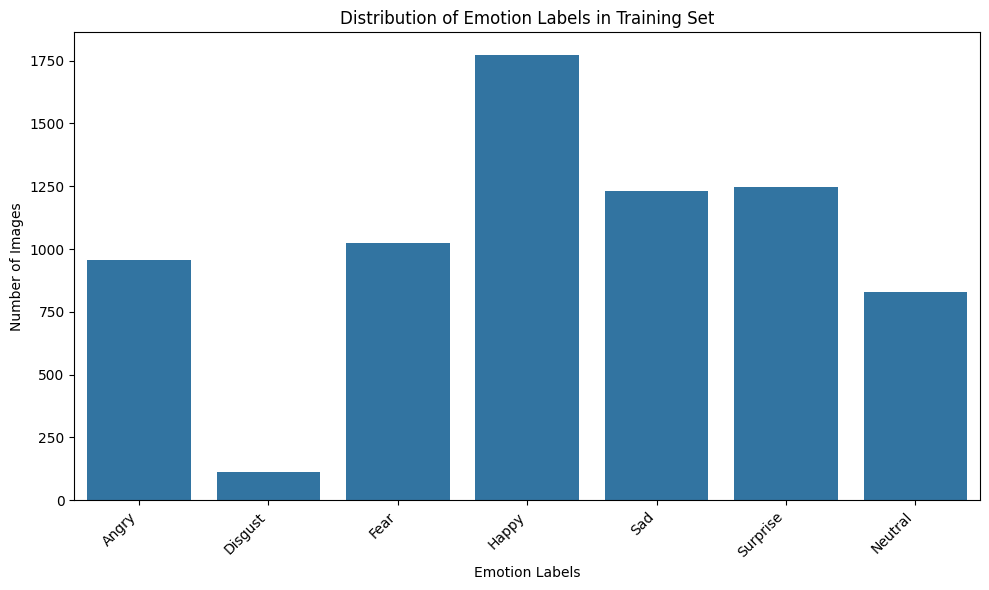

In [ ]:
plot_label_distribution('test')

In [ ]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], id=None)}

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [ ]:
label2id

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

# Data Transformation

In [ ]:
# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = image_processor.image_mean, image_processor.image_std

# Get the size (height) of the ViT model's input images
size = image_processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
train_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        RandomHorizontalFlip(0.5),        # Random horizontal flip
        ToTensor(),                       # Convert images to tensors
        normalize                          # Normalize images using mean and std
    ]
)
# Define a set of transformations for validation data
val_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)

Size:  224


In [ ]:
# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [train_tf(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [val_tf(image.convert("RGB")) for image in examples['image']]
    return examples

In [ ]:
# # split up training into training + validation
# splits = dataset["train"].train_test_split(test_size=0.2)
train_data = dataset['train']
val_data = dataset['test']

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 28709
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 7178
    })
})

In [ ]:
train_data

Dataset({
    features: ['image', 'label'],
    num_rows: 28709
})

In [ ]:
val_data

Dataset({
    features: ['image', 'label'],
    num_rows: 7178
})

In [ ]:
train_data.set_transform(train_transforms)
val_data.set_transform(val_transforms)

In [ ]:
train_data[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=48x48>,
 'label': 0,
 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -

In [ ]:
val_data[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=48x48>,
 'label': 0,
 'pixel_values': tensor([[[-0.6392, -0.6392, -0.6392,  ..., -0.8275, -0.8275, -0.8275],
          [-0.6392, -0.6392, -0.6392,  ..., -0.8275, -0.8275, -0.8275],
          [-0.6392, -0.6392, -0.6392,  ..., -0.8275, -0.8275, -0.8275],
          ...,
          [ 0.6314,  0.6314,  0.6314,  ...,  0.4902,  0.4902,  0.4902],
          [ 0.6314,  0.6314,  0.6314,  ...,  0.4824,  0.4824,  0.4824],
          [ 0.6314,  0.6314,  0.6314,  ...,  0.4824,  0.4824,  0.4824]],
 
         [[-0.6392, -0.6392, -0.6392,  ..., -0.8275, -0.8275, -0.8275],
          [-0.6392, -0.6392, -0.6392,  ..., -0.8275, -0.8275, -0.8275],
          [-0.6392, -0.6392, -0.6392,  ..., -0.8275, -0.8275, -0.8275],
          ...,
          [ 0.6314,  0.6314,  0.6314,  ...,  0.4902,  0.4902,  0.4902],
          [ 0.6314,  0.6314,  0.6314,  ...,  0.4824,  0.4824,  0.4824],
          [ 0.6314,  0.6314,  0.6314,  ...,  0.4824,  0.4824,  0.4824]],
 


In [ ]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

In [ ]:
notebook_login()

In [ ]:
import transformers
print(transformers.__version__)

4.51.3


In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}",
    remove_unused_columns=False,
    eval_strategy="steps",
    save_strategy="steps",  # Align with evaluation_strategy
    learning_rate=3e-5,
    lr_scheduler_type="cosine",
    auto_find_batch_size=True,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=32,
    weight_decay=0.1,
    num_train_epochs=3,
    warmup_steps=1000,
    logging_steps=50,
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    report_to="none"
)


In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Model Development
## Training

In [ ]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    references = eval_pred.label_ids

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=references)["accuracy"],
        "f1": f1_metric.compute(predictions=predictions, references=references, average="macro")["f1"]
    }


trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

<ipython-input-58-89419ac602dc>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
100,0.528100,0.255426,0.912789,0.911567
200,0.527800,0.254023,0.913625,0.912723
300,0.499300,0.259242,0.911535,0.909823


## Evaluation

In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       2.98
  eval_accuracy           =     0.9136
  eval_f1                 =     0.9139
  eval_loss               =     0.2564
  eval_runtime            = 0:01:34.69
  eval_samples_per_second =     75.803
  eval_steps_per_second   =      2.376


In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       2.98
  eval_accuracy           =     0.9136
  eval_f1                 =     0.9139
  eval_loss               =     0.2564
  eval_runtime            = 0:01:34.20
  eval_samples_per_second =     76.196
  eval_steps_per_second   =      2.388


In [ ]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/shrestha1/vit-Facial-Expression-Recognition/commit/103a08f22597d137c50295523e5b48e432a75f75', commit_message='End of training', commit_description='', oid='103a08f22597d137c50295523e5b48e432a75f75', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shrestha1/vit-Facial-Expression-Recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='shrestha1/vit-Facial-Expression-Recognition'), pr_revision=None, pr_num=None)

In [ ]:
# Use the trained 'trainer' to make predictions on the 'test_data'.
outputs = trainer.predict(val_data)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 0.25640869140625, 'test_accuracy': 0.9136249651713569, 'test_f1': 0.9139029699461804, 'test_runtime': 99.3935, 'test_samples_per_second': 72.218, 'test_steps_per_second': 2.264}


## Testing

In [ ]:
pipe=pipeline(model = 'shrestha1/vit-Facial-Expression-Recognition')

config.json:   0%|          | 0.00/898 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Load the image file
image_path = '/kaggle/input/testing-fer/testing_FER/happy2.jpg'  # Replace with the actual path to your image file
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/testing-fer/testing_FER/happy2.jpg'

In [ ]:
from transformers import pipeline

pipe=pipeline(model = 'shrestha1/vit-Facial-Expression-Recognition')
pipe("/kaggle/input/testing-fer/testing_FER/happy2.jpg")

Accuracy: 0.9140
F1 Score: 0.9073


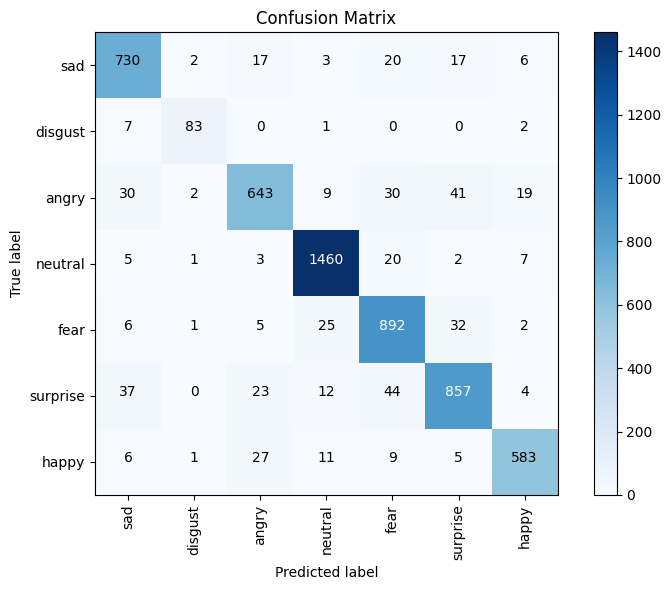


Classification report:

              precision    recall  f1-score   support

         sad     0.8892    0.9182    0.9035       795
     disgust     0.9222    0.8925    0.9071        93
       angry     0.8955    0.8307    0.8619       774
     neutral     0.9599    0.9746    0.9672      1498
        fear     0.8788    0.9263    0.9019       963
    surprise     0.8983    0.8772    0.8876       977
       happy     0.9358    0.9081    0.9217       642

    accuracy                         0.9140      5742
   macro avg     0.9114    0.9039    0.9073      5742
weighted avg     0.9140    0.9140    0.9136      5742



In [ ]:
labels_list = ['sad', 'disgust', 'angry', 'neutral', 'fear', 'surprise', 'happy'] # list(set(labels))
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

Accuracy: 0.9136
F1 Score: 0.9139


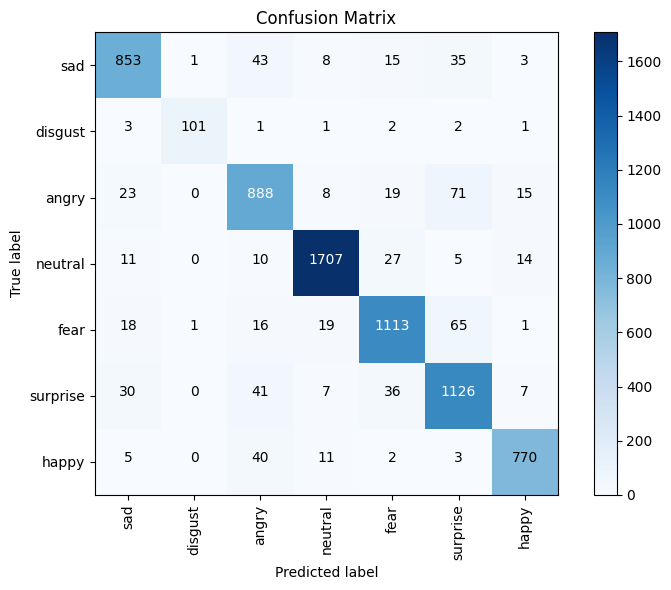


Classification report:

              precision    recall  f1-score   support

         sad     0.9046    0.8904    0.8974       958
     disgust     0.9806    0.9099    0.9439       111
       angry     0.8547    0.8672    0.8609      1024
     neutral     0.9693    0.9622    0.9658      1774
        fear     0.9168    0.9027    0.9097      1233
    surprise     0.8615    0.9030    0.8818      1247
       happy     0.9494    0.9266    0.9379       831

    accuracy                         0.9136      7178
   macro avg     0.9196    0.9089    0.9139      7178
weighted avg     0.9144    0.9136    0.9139      7178



In [ ]:
labels_list = ['sad', 'disgust', 'angry', 'neutral', 'fear', 'surprise', 'happy'] # list(set(labels))
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))